### Generate the moons dataset

In [1]:
from sklearn.datasets import make_moons
from matplotlib import pyplot as plt
import numpy as np

In [2]:
data = make_moons(noise=0.2, random_state=0, n_samples=1000)

In [3]:
samples, labels = np.asarray(data[0]), np.asarray(data[1])

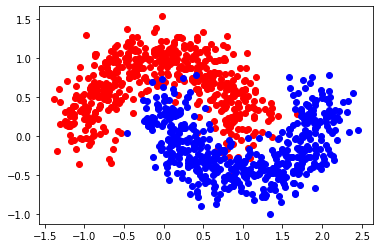

In [4]:
class_0 = samples[labels == 0]
class_1 = samples[labels == 1]
plt.scatter(class_0[:, 0], class_0[:, 1], color='r')
plt.scatter(class_1[:, 0], class_1[:, 1], color='b')
plt.show()

In [5]:
def split(samples, labels, test_size=0.2, images=True):
    from sklearn.model_selection import StratifiedShuffleSplit

    sss = StratifiedShuffleSplit(test_size=test_size, random_state=0)
    train_index, test_index = list(sss.split(samples, labels))[0]
    if images:
        train_samples = samples[train_index, :, :]
        test_samples = samples[test_index, :, :]
    else:
        train_samples = samples[train_index]
        test_samples = samples[test_index]
        
    train_labels = labels[train_index]
    test_labels = labels[test_index]

    return train_samples, train_labels, test_samples, test_labels

In [6]:
train_samples, train_labels, test_samples, test_labels = split(samples, labels, images=False)

## Define prerequisites for models

In [7]:
num_classes = 2
num_epochs = 100

In [19]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

tfd = tfp.distributions

In [9]:
### The functions below are used according to the documentation 
# (https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/bayesian_neural_network.py) 
# to specify a prior and a surrogate posterior over variational layers in tensorflow probability

# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  c = np.log(np.expm1(1.))
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])

# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
  ])

# define the kl divergence function according to the docs 
# to work as a distance between prior and posterior distributions
kl_divergence_function = (lambda q, p, _: tfp.distributions.kl_divergence(q, p) / 
                    tf.cast(len(train_samples), dtype=tf.float32))

### Below there are three blocks, each defining the variable `model` and compiling the model. Run either of these three, and then the one after these to fit the model. There is a sanity check for the best performing model at the end of the notebook.

In [20]:
# For the moons dataset this model using Bayesian variational inference
# using the Flipout estimator had the best results
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=2),
    tfp.layers.DenseFlipout(
        units=2,
        activation='tanh',
        kernel_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
        bias_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
        kernel_divergence_fn=kl_divergence_function),
    tfp.layers.DenseFlipout(
        units=1,
        activation='sigmoid',
        kernel_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
        bias_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
        kernel_divergence_fn=kl_divergence_function)
])

model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

In [63]:
# The same model, but without the Flipout estimator
# Performance no better than a random uniform classifier on the moons dataset
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=2),
    tfp.layers.DenseVariational(
        units=2,
        activation='tanh',
        make_posterior_fn=posterior_mean_field,
        make_prior_fn=prior_trainable,
        kl_weight=1/train_samples.shape[0]),
    tfp.layers.DenseVariational(
        units=1,
        activation='sigmoid',
        make_posterior_fn=posterior_mean_field,
        make_prior_fn=prior_trainable,
        kl_weight=1/train_samples.shape[0])
])

model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

In [72]:
# The same model, but using the reparametrization parameter
# Performance no better than a random uniform classifier on the moons dataset
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=2),
    tfp.layers.DenseReparameterization(
        units=2,
        activation='tanh'),
    tfp.layers.DenseReparameterization(
        units=1,
        activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

In [21]:
model.fit(train_samples, train_labels, epochs=num_epochs, validation_split=0.2)

Epoch 1/100
20/20 [==============================] - 1s 18ms/step - loss: 0.7145 - accuracy: 0.4960 - val_loss: 0.7102 - val_accuracy: 0.5250
Epoch 2/100
20/20 [==============================] - 0s 4ms/step - loss: 0.7126 - accuracy: 0.5506 - val_loss: 0.7103 - val_accuracy: 0.5562
Epoch 3/100
20/20 [==============================] - 0s 4ms/step - loss: 0.7145 - accuracy: 0.4884 - val_loss: 0.7094 - val_accuracy: 0.5562
Epoch 4/100
20/20 [==============================] - 0s 4ms/step - loss: 0.7147 - accuracy: 0.4830 - val_loss: 0.7127 - val_accuracy: 0.4750
Epoch 5/100
20/20 [==============================] - 0s 4ms/step - loss: 0.7138 - accuracy: 0.4763 - val_loss: 0.7087 - val_accuracy: 0.5437
Epoch 6/100
20/20 [==============================] - 0s 4ms/step - loss: 0.7118 - accuracy: 0.5461 - val_loss: 0.7123 - val_accuracy: 0.5000
Epoch 7/100
20/20 [==============================] - 0s 4ms/step - loss: 0.7131 - accuracy: 0.5083 - val_loss: 0.7103 - val_accuracy: 0.5938
Epoch 8/100


In [ ]:
from sklearn.metrics import accuracy_score

predictions = model.predict_classes(test_samples)

print(accuracy_score(test_labels, predictions))

## Plot weights posterior distributions

In [25]:
def plot_weight_posteriors_moons_model(layers):
    f, a = plt.subplots(3,2)
    a = a.ravel()

    layer_weights = np.asarray([layers[0].kernel_posterior.sample().numpy()
                                for _ in range(50)])
    w_11 = layer_weights[:, 0, 0]
    w_12 = layer_weights[:, 0, 1]
    w_21 = layer_weights[:, 1, 0]
    w_22 = layer_weights[:, 1, 1]

    layer_weights = np.asarray([layers[1].kernel_posterior.sample().numpy()
                                for _ in range(50)])
    
    w_31 = layer_weights[:, 0]
    w_32 = layer_weights[:, 1]

    a[0].hist(w_11, label='w_11')
    a[1].hist(w_12, label='w_12')
    a[2].hist(w_21, label='w_21')
    a[3].hist(w_22, label='w_22')
    a[4].hist(w_31, label='w_31')
    a[5].hist(w_32, label='w_32')

    for i in range(6):
        a[i].legend(loc='upper_right')
        

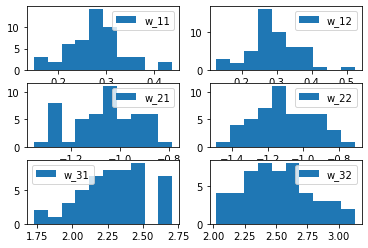

In [21]:
plot_weight_posteriors_moons_model(model.layers)

## Comparing this model to one with the same architecture, but no variational inference.

In [22]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=2),
    tf.keras.layers.Dense(
        units=2,
        activation='tanh'),
    tf.keras.layers.Dense(
        units=1,
        activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

model.fit(train_samples, train_labels, epochs=num_epochs, validation_split=0.2)

Epoch 1/100
20/20 [==============================] - 0s 11ms/step - loss: 0.6627 - accuracy: 0.6519 - val_loss: 0.6473 - val_accuracy: 0.7125
Epoch 2/100
20/20 [==============================] - 0s 18ms/step - loss: 0.6572 - accuracy: 0.6733 - val_loss: 0.6461 - val_accuracy: 0.7125
Epoch 3/100
20/20 [==============================] - 0s 4ms/step - loss: 0.6616 - accuracy: 0.6197 - val_loss: 0.6449 - val_accuracy: 0.7188
Epoch 4/100
20/20 [==============================] - 0s 4ms/step - loss: 0.6565 - accuracy: 0.6773 - val_loss: 0.6437 - val_accuracy: 0.7188
Epoch 5/100
20/20 [==============================] - 0s 4ms/step - loss: 0.6567 - accuracy: 0.6780 - val_loss: 0.6425 - val_accuracy: 0.7250
Epoch 6/100
20/20 [==============================] - 0s 4ms/step - loss: 0.6601 - accuracy: 0.6515 - val_loss: 0.6413 - val_accuracy: 0.7437
Epoch 7/100
20/20 [==============================] - 0s 4ms/step - loss: 0.6551 - accuracy: 0.6971 - val_loss: 0.6401 - val_accuracy: 0.7625
Epoch 8/100

In [23]:
from sklearn.metrics import accuracy_score

predictions = model.predict_classes(test_samples)

print(accuracy_score(test_labels, predictions))

0.865


## Below there is an attempt at a convolutional bayesian network trained on MNIST digits. However, despite different estimators and architectures, accuracy does not seem to rise much, revolving mostly around 10%. The best validation accuracy obatined was around 30-40%. Therefore, comparison with a usual CNN has not been considered releant.

In [28]:
# MNIST
from sklearn.datasets import load_digits

digits = load_digits()
data = digits.images
labels = digits.target

In [29]:
train_samples, train_labels, test_samples, test_labels = split(data, labels)

In [39]:
# define Convolutional BNN

bnn_model = tf.keras.models.Sequential([
    tfp.layers.Convolution2DReparameterization(
        256, kernel_size=5, padding='SAME',
        kernel_divergence_fn=kl_divergence_function,
        activation=tf.nn.relu,
        data_format="channels_last"),
    tf.keras.layers.MaxPooling2D(
        pool_size=[2, 2], padding='SAME',
        data_format="channels_last"),
    tfp.layers.Convolution2DReparameterization(
        256, kernel_size=5, padding='SAME',
        kernel_divergence_fn=kl_divergence_function,
        activation=tf.nn.relu,
        data_format="channels_last"),
    tf.keras.layers.MaxPooling2D(
        pool_size=[2, 2], padding='SAME',
        data_format="channels_last"),
    tfp.layers.Convolution2DReparameterization(
        256, kernel_size=3, padding='SAME',
        kernel_divergence_fn=kl_divergence_function,
        activation=tf.nn.relu,
        data_format="channels_last"),
    tf.keras.layers.MaxPooling2D(
        pool_size=[2, 2], padding='SAME',
        data_format="channels_last"),
    tfp.layers.Convolution2DReparameterization(
        256, kernel_size=3, padding='SAME',
        kernel_divergence_fn=kl_divergence_function,
        activation=tf.nn.relu,
        data_format="channels_last"),
    tf.keras.layers.MaxPooling2D(
        pool_size=[2, 2], padding='SAME',
        data_format="channels_last"),
    tf.keras.layers.Flatten(),
    tfp.layers.DenseReparameterization(
        84, kernel_divergence_fn=kl_divergence_function,
        activation=tf.nn.relu),
    tfp.layers.DenseReparameterization(
        42, kernel_divergence_fn=kl_divergence_function,
        activation=tf.nn.relu),
    tfp.layers.DenseReparameterization(
        10, kernel_divergence_fn=kl_divergence_function,
        activation=tf.nn.softmax)
])

bnn_model.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [40]:
# reshape because the 2d convs expect 3d images
train_samples = train_samples.reshape((train_samples.shape[0], train_samples.shape[1], train_samples.shape[2], 1))
test_samples = test_samples.reshape((test_samples.shape[0], test_samples.shape[1], test_samples.shape[2], 1))

bnn_model.fit(train_samples, train_labels, batch_size=128, epochs=20, validation_split=0.2)

Epoch 1/20
9/9 [==============================] - 9s 737ms/step - loss: 5546.4619 - accuracy: 0.0958 - val_loss: 4957.4297 - val_accuracy: 0.1111
Epoch 2/20
9/9 [==============================] - 6s 630ms/step - loss: 4915.7903 - accuracy: 0.0914 - val_loss: 4825.7466 - val_accuracy: 0.0799
Epoch 3/20
9/9 [==============================] - 6s 632ms/step - loss: 4799.6043 - accuracy: 0.0950 - val_loss: 4717.6138 - val_accuracy: 0.1007
Epoch 4/20
9/9 [==============================] - 6s 631ms/step - loss: 4689.8776 - accuracy: 0.1034 - val_loss: 4604.8262 - val_accuracy: 0.1215
Epoch 5/20
9/9 [==============================] - 6s 631ms/step - loss: 4576.9729 - accuracy: 0.1200 - val_loss: 4490.1167 - val_accuracy: 0.1250
Epoch 6/20
9/9 [==============================] - 6s 632ms/step - loss: 4461.8451 - accuracy: 0.1082 - val_loss: 4373.6118 - val_accuracy: 0.0903
Epoch 7/20
9/9 [==============================] - 6s 630ms/step - loss: 4344.8961 - accuracy: 0.1338 - val_loss: 4255.7593 -

# Sanity check for flipout model

Epoch 1/20
3/3 [==============================] - 1s 192ms/step - loss: 0.7167 - accuracy: 0.4578 - val_loss: 0.7116 - val_accuracy: 0.5500
Epoch 2/20
3/3 [==============================] - 0s 33ms/step - loss: 0.7076 - accuracy: 0.5945 - val_loss: 0.7095 - val_accuracy: 0.4500
Epoch 3/20
3/3 [==============================] - 0s 34ms/step - loss: 0.7102 - accuracy: 0.4883 - val_loss: 0.7034 - val_accuracy: 0.6500
Epoch 4/20
3/3 [==============================] - 0s 33ms/step - loss: 0.7010 - accuracy: 0.6273 - val_loss: 0.6992 - val_accuracy: 0.8500
Epoch 5/20
3/3 [==============================] - 0s 33ms/step - loss: 0.6985 - accuracy: 0.5445 - val_loss: 0.6940 - val_accuracy: 0.8000
Epoch 6/20
3/3 [==============================] - 0s 32ms/step - loss: 0.6903 - accuracy: 0.8000 - val_loss: 0.6928 - val_accuracy: 0.6000
Epoch 7/20
3/3 [==============================] - 0s 31ms/step - loss: 0.6775 - accuracy: 0.9109 - val_loss: 0.6754 - val_accuracy: 0.6500
Epoch 8/20
3/3 [==========

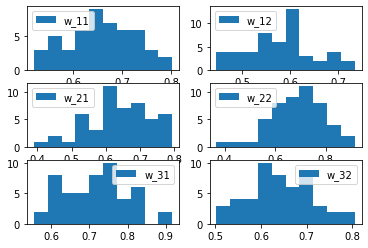

In [27]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=2),
    tfp.layers.DenseFlipout(
        units=2,
        activation='tanh',
        kernel_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
        bias_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
        kernel_divergence_fn=kl_divergence_function),
    tfp.layers.DenseFlipout(
        units=1,
        activation='sigmoid',
        kernel_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
        bias_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
        kernel_divergence_fn=kl_divergence_function)
])

model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

X = np.random.randn(100, 2)
Y = np.tanh(X[:, 0] + X[:, 1])
Y = 1. / (1. + np.exp(-(Y + Y)))
Y = Y > 0.5

model.fit(X, Y, epochs=20, validation_split=0.2)

plot_weight_posteriors_moons_model(model.layers)